In [1]:
import pandas as pd
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.stats import iqr

## Leitura e limpeza do csv com colunas específicas

In [2]:
def leitor_csv_zip(caminho_zip: str, colunas: list[str]) -> pd.DataFrame:
    """
    Lê um CSV de dentro de um arquivo .zip, usando apenas as colunas necessárias.
    """
    try:
        with zipfile.ZipFile(caminho_zip, 'r') as z:
            # lista todos os arquivos dentro do zip
            arquivos = z.namelist()
            # pega só os que terminam com .csv
            csvs = [arq for arq in arquivos if arq.lower().endswith(".csv")]

            if not csvs:
                print(f"Nenhum arquivo .csv encontrado dentro de {caminho_zip}")
                return pd.DataFrame()

            # por simplicidade, vamos usar o primeiro CSV encontrado
            csv_principal = csvs[0]
            print(f"Lendo {csv_principal} de dentro de {caminho_zip}")

            with z.open(csv_principal) as f:
                quadro = pd.read_csv(f, usecols=colunas, low_memory=False)

        # Padroniza colunas para minúsculas, igual ao leitor de .csv solto
        quadro.columns = [c.lower() for c in quadro.columns]
        return quadro

    except Exception as e:
        print(f"Erro ao ler {caminho_zip}: {e}")
        return pd.DataFrame()


def leitor_geral_especifico_zip(caminhos_zip: list[str], colunas: list[str]) -> pd.DataFrame:
    """
    Lê vários .zip (cada um contendo um CSV de dengue) e concatena tudo em um único DataFrame.
    """
    dados_finais = pd.DataFrame()

    for caminho in caminhos_zip:
        quadro = leitor_csv_zip(caminho, colunas)
        if not quadro.empty:
            dados_finais = pd.concat([dados_finais, quadro], ignore_index=True)

    print(f"Total de linhas após leitura geral (zip): {len(dados_finais)}")
    print(f"Colunas do DataFrame final: {list(dados_finais.columns)}")
    return dados_finais

def converter_datas(quadro: pd.DataFrame) -> pd.DataFrame:
    """
    Converte DT_SIN_PRI e DT_NOTIFIC para datetime.
    """
    if "dt_sin_pri" in quadro.columns:
        quadro["dt_sin_pri"] = pd.to_datetime(
            quadro["dt_sin_pri"],
            errors="coerce"
        )

    if "dt_notific" in quadro.columns:
        quadro["dt_notific"] = pd.to_datetime(
            quadro["dt_notific"],
            errors="coerce"
        )

    return quadro

def filtrar_ano_minimo(quadro: pd.DataFrame, ano_minimo: int = 2020) -> pd.DataFrame:
    """
    Remove linhas com NU_ANO menor que 'ano_minimo' (padrão: 2020).

    Útil para descartar notificações de 2019 que aparecem no CSV de 2020,
    mas que não queremos considerar na análise 2020–2025.
    """
    if "nu_ano" not in quadro.columns:
        print("Aviso: coluna 'nu_ano' não encontrada. Nenhum filtro de ano aplicado.")
        return quadro

    # Garante que nu_ano é numérico
    quadro["nu_ano"] = pd.to_numeric(quadro["nu_ano"], errors="coerce")

    antes = len(quadro)
    quadro_filtrado = quadro[quadro["nu_ano"] >= ano_minimo].copy()
    depois = len(quadro_filtrado)

    print(f"Filtrar ano >= {ano_minimo}: {antes} -> {depois} linhas.")
    return quadro_filtrado

## Filtragem classificados com dengue

In [3]:
# Remove casos com classi_fin considerado descartado
def filtrar_classificados(quadro: pd.DataFrame) -> pd.DataFrame:
    """
    Remove casos descartados (CLASSI_FIN == 5).
    """
    if "classi_fin" not in quadro.columns:
        print("Aviso: coluna 'classi_fin' não encontrada. Nenhum filtro aplicado.")
        return quadro

    quadro["classi_fin"] = pd.to_numeric(quadro["classi_fin"], errors="coerce")
    antes = len(quadro)
    quadro_filtrado = quadro[quadro["classi_fin"] != 5].copy()
    depois = len(quadro_filtrado)

    print(f"Filtrar classificados: {antes} -> {depois} linhas (descartados removidos).")
    return quadro_filtrado

## Mapeamento IBGE

In [4]:
UF_IBGE = {
    "AC": 12, "AL": 27, "AP": 16, "AM": 13, "BA": 29, "CE": 23,
    "DF": 53, "ES": 32, "GO": 52, "MA": 21, "MT": 51, "MS": 50,
    "MG": 31, "PA": 15, "PB": 25, "PR": 41, "PE": 26, "PI": 22,
    "RJ": 33, "RN": 24, "RS": 43, "RO": 11, "RR": 14, "SC": 42,
    "SP": 35, "SE": 28, "TO": 17
}

CODIGO_PARA_UF = {v: k for k, v in UF_IBGE.items()}

## Contagem por UF

In [5]:
def contagem_casos_por_uf(quadro: pd.DataFrame) -> pd.DataFrame:
    """
    Conta o número total de casos por UF de notificação (SG_UF_NOT),
    para o Brasil inteiro (após filtros de classificação e ano).
    """
    if "sg_uf_not" not in quadro.columns:
        raise KeyError("Coluna 'sg_uf_not' não encontrada no DataFrame.")

    df = quadro.copy()
    df["sg_uf_not"] = pd.to_numeric(df["sg_uf_not"], errors="coerce")
    df = df[df["sg_uf_not"].notna()]

    contagem = (
        df.groupby("sg_uf_not", as_index=False)
          .size()
          .rename(columns={"size": "casos"})
    )

    # Mapeia código -> sigla
    contagem["uf_sigla"] = contagem["sg_uf_not"].map(CODIGO_PARA_UF)

    # Total nacional para calcular proporção
    total_nacional = contagem["casos"].sum()
    contagem["proporcao"] = contagem["casos"] / total_nacional

    # Ordena do maior para o menor
    contagem = contagem.sort_values("casos", ascending=False).reset_index(drop=True)

    return contagem


## Graficos

In [6]:
def grafico_distribuicao_casos_por_uf(
    tabela_uf: pd.DataFrame,
    titulo: str = "Distribuição de casos de dengue por UF (Brasil, 2020–2025)",
    caminho_saida: str | None = None
):
    """
    Plota um gráfico de barras com o total de casos por UF.
    """
    if tabela_uf.empty:
        print("Tabela por UF vazia – nenhum gráfico gerado.")
        return

    # Garante ordenação
    df = tabela_uf.sort_values("casos", ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(
        data=df,
        x="uf_sigla",
        y="casos"
    )

    plt.title(titulo)
    plt.xlabel("UF de notificação")
    plt.ylabel("Número de casos")
    plt.tight_layout()

    if caminho_saida:
        os.makedirs(os.path.dirname(caminho_saida), exist_ok=True)
        plt.savefig(caminho_saida, dpi=300)
        print(f"Gráfico salvo em: {caminho_saida}")

    plt.show()

## Execução completa

Lendo DENGBR20.csv de dentro de dados/DENGBR20.zip
Lendo DENGBR21.csv de dentro de dados/DENGBR21.zip
Lendo DENGBR22.csv de dentro de dados/DENGBR22.zip
Lendo DENGBR23.csv de dentro de dados/DENGBR23.zip
Lendo DENGBR24.csv de dentro de dados/DENGBR24.zip
Lendo DENGBR25.csv de dentro de dados/DENGBR25.zip
Total de linhas após leitura geral (zip): 13344402
Colunas do DataFrame final: ['dt_notific', 'sem_not', 'nu_ano', 'sg_uf_not', 'dt_sin_pri', 'nu_idade_n', 'cs_sexo', 'classi_fin']
Filtrar classificados: 13344402 -> 12327380 linhas (descartados removidos).
Filtrar ano >= 2020: 12327380 -> 12323901 linhas.

Distribuição de casos de dengue por UF (Brasil, 2020–2025):
    sg_uf_not    casos uf_sigla  proporcao
0          35  4086148       SP   0.331563
1          31  2419309       MG   0.196310
2          41  1422300       PR   0.115410
3          52   818931       GO   0.066451
4          42   622853       SC   0.050540
5          53   471580       DF   0.038265
6          29   448087   

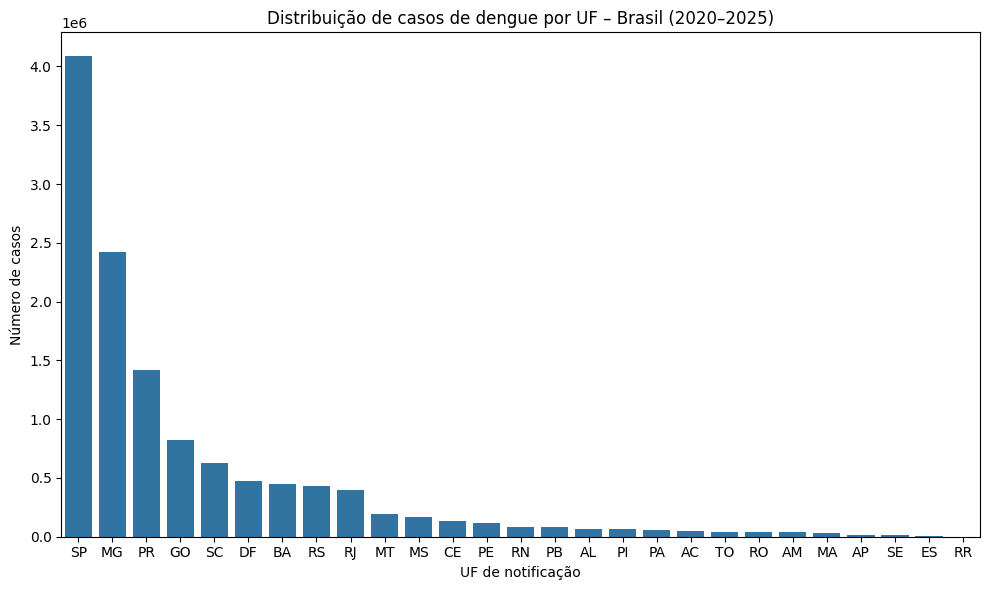

In [7]:
def executar_distribuicao_casos_por_estado_brasil(
    caminhos_zip: list[str],
    colunas_necessarias: list[str]
):
    # 1) Leitura e limpeza
    dados = leitor_geral_especifico_zip(caminhos_zip, colunas_necessarias)
    dados = converter_datas(dados)
    dados = filtrar_classificados(dados)
    dados = filtrar_ano_minimo(dados, ano_minimo=2020)

    # 2) Contagem por UF (Brasil inteiro)
    tabela_uf = contagem_casos_por_uf(dados)

    print("\nDistribuição de casos de dengue por UF (Brasil, 2020–2025):")
    print(tabela_uf)

    # 3) Gráfico
    grafico_distribuicao_casos_por_uf(
        tabela_uf,
        titulo="Distribuição de casos de dengue por UF – Brasil (2020–2025)",
        caminho_saida="resultados/distribuicao_casos_por_uf_brasil.png"
    )


caminhos_zip = [
    "dados/DENGBR20.zip",
    "dados/DENGBR21.zip",
    "dados/DENGBR22.zip",
    "dados/DENGBR23.zip",
    "dados/DENGBR24.zip",
    "dados/DENGBR25.zip",
]

colunas_necessarias = [
    "DT_NOTIFIC",
    "SEM_NOT",
    "NU_ANO",
    "SG_UF_NOT",
    "DT_SIN_PRI",
    "NU_IDADE_N",
    "CS_SEXO",
    "CLASSI_FIN",
]

executar_distribuicao_casos_por_estado_brasil(caminhos_zip, colunas_necessarias)